In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston # 사이킷런 내장된 보스턴 주택가격 데이터 셋
%matplotlib inline

## boston 데이터 세트 로드 -> DataFrame 변환 

In [2]:
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# 1. 초간단 EDA

In [3]:
# target(y)는 주택가격. -> PRICE 칼럼을 만들어서 DataFrame에 추가
bostonDF['PRICE'] = boston.target   # 타켓으로 이미 지정되어 있기 때문에 이렇게 추가된건가?
print('Boston 데이터 세트 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


### 각 칼럼이 회귀 결과에 미치는 영향이 어느 정도인지 시각화로 알아보기. (각 칼럼이 값 변화에 따라 PRICE 값이 어떻게 변화하는가)
#### Seaborn의 regplot()은 X,Y축 값의 산점도와 함께 선형 회귀 직선을 그려줌.
#### matplotlib의 subplots()은 여러 개의 그래프를 한번에 표현하기 위해 사용.

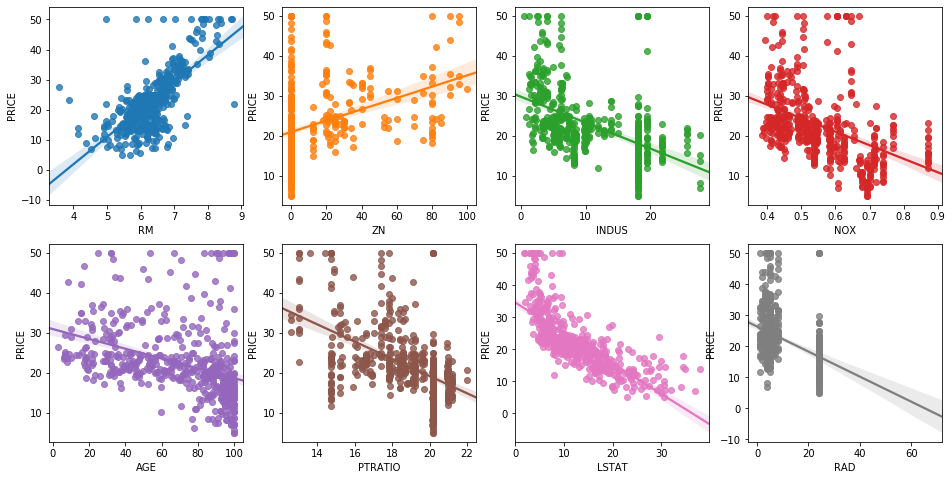

In [5]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS','NOX','AGE','PTRATIO','LSTAT','RAD'] # RM : 방 개수 , LSTAT : 하위계층비율
# RM : 양 방향 선형성이 크다.   LSTAT : 음 바향 선형성이 가장 크다 즉, 적을 수록 PRICE가 증가한다.
for i, feature in enumerate(lm_features):    # enumerate: 열거하다
    row = int(i/4)
    col = i%4
    
    # Seaborn의 regplot 이용
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

# 2. 선형회귀 클래스 이용해 회귀모델 만들기
## - 데이터셋 분리 : 7:3, 임의(Random)분리사용 -> 이후 교차검증은 K-Fold(5단계) 사용
## - 모델학습 단계
## - 검증평가 : mean_squared_error()(MSE), (RMSE) /  r2_score()(R2)
### - 일반적으로 회귀는 MSE값이 낮을 수록 좋은 회귀 모델

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)   # PRICE : y값으로 사용되니 x에서는 분리. 실제 DF에는 적용되지 않게 False로

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

# 검증평가
mse = mean_squared_error(y_test, y_preds)
rmse=np.sqrt(mse)

print('MSE : {0:.3f}. RMSE : {1:.3F}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))  # r2 score

MSE : 17.297. RMSE : 4.159
Variance score : 0.757


# LR로 생성한 주택가격 모델의 intercept(절편), coefficients(회귀 계수) 값 확인 

In [7]:
# print('절편 값:', lr.intercept_)   # lr된 결과에서 가져온 것
print('회귀 계수값:', np.round(lr.coef_, 1))  # lr된 결과에서 가져온 것

# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. X 칼럼들에 매핑
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)


# RM(거주방개수) 이 양의 값으로 회귀 계수가 가장 큼. NOX(일산화질소농도)의 음의 값이 너무 큼.

회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [8]:
# 5 Folds 교차검증

# 다시 예측모델
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5폴드 세트로 MSE를 구한 뒤 
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
# 이를 기반으로 다시 RMSE 구함.
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error") 로 반환된 값을 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ',np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ',np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


# # RM(거주방개수) 이 양의 값으로 회귀 계수가 가장 큼. NOX(일산화질소농도)의 음의 값이 너무 큼.

# 5 folds 의 평균 RMSE : 5.829 